# General import functions

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

from igraph import *
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_csv
import anndata

sc.logging.print_versions()

scanpy==1.4.5.1 anndata==0.6.22 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
pwd

'/home/angela/sapiens/tabula-sapiens/analysis-scripts/pilot2'

# Load the data

List all the data available

In [11]:
path = '/mnt/ibm_lg/angela/sapiens/TSP2/10X/'

In [12]:
import os
pilot2_runs = [x[1] for x in os.walk(path)][0]
pilot2_runs

['TSP2_Blood_NA_1_3',
 'TSP2_Lung_proxmedialdistal_1_1',
 'TSP2_LI_proximal_1_1',
 'TSP2_Thymus_NA_1_3_5prime',
 'TSP2_Spleen_NA_2_1',
 'TSP2_SI_proximal_1_1',
 'TSP2_Kidney_NA_1_2',
 'TSP2_Thymus_NA_1_2',
 'TSP2_Blood_NA_2_1',
 'TSP2_Bladder_NA_1_1',
 'TSP2_Bladder_NA_1_2',
 'TSP2_Spleen_NA_1_1',
 'TSP2_BM_vertebralbody_2_1',
 'TSP2_SI_distal_1_1',
 'TSP2_Trachea_NA_1_2',
 'TSP2_Muscle_diaphragm_1_2',
 'TSP2_Heart_ventricle_1_1',
 'TSP2_Thymus_NA_1_4_5prime',
 'TSP2_BM_vertebralbody_1_1',
 'TSP2_Muscle_rectusabdominus_1_1',
 'TSP2_Blood_NA_1_5_5prime',
 'TSP2_Kidney_NA_1_1',
 'TSP2_Vasculature_Aorta_1_2',
 'TSP2_BM_vertebralbody_1_2_5prime',
 'TSP2_BM_vertebralbody_2_2_5prime',
 'TSP2_Vasculature_Aorta_1_1',
 'TSP2_Lung_proxmedialdistal_1_2',
 'TSP2_LymphNode_NA_1_1',
 'TSP2_LI_distal_1_1',
 'TSP2_Trachea_NA_1_1',
 'TSP2_Thymus_NA_1_1',
 'TSP2_Muscle_diaphragm_1_1',
 'TSP2_Muscle_rectusabdominus_1_2',
 'TSP2_LymphNode_NA_2_1']

In [ ]:
adata = sc.AnnData()

for r in pilot2_runs:
    
    print(r)
    adataaux = sc.read_10x_mtx(path+r+'/raw_feature_bc_matrix/',cache=True)
    
    bfcmingenes = adataaux.shape[0]
    sc.pp.filter_cells(adataaux, min_genes=100)
    adataaux.obs['filter_cells_min_genes'] = bfcmingenes-adataaux.shape[0] #no droplets lost
    bfcmincounts = adataaux.shape[0]
    sc.pp.filter_cells(adataaux, min_counts=1000)
    adataaux.obs['filter_cells_min_counts'] = bfcmincounts-adataaux.shape[0] #no droplets lost
    bfgmincells = adataaux.shape[0]
#     sc.pp.filter_genes(adataaux, min_cells=1)
#     adataaux.obs['filter_genes_min_cells'] = bfgmincells-adataaux.shape[0] #no genes lost
    adataaux.obs['pilot'] = r.split('_')[0]  
    adataaux.obs['tissue'] = r.split('_')[1]  
    adataaux.obs['subtissue'] = r.split('_')[2]  
    adataaux.obs['sample'] = r.split('_')[3]  
    adataaux.obs['replicate'] = r.split('_')[4]
   
    try:
        adataaux.obs['notes'] = r.split('_')[5]
    except:
        print("no notes to add")
    
    try:
        adata = adata.concatenate(adataaux)
        adata.obs = adata.obs.drop('batch',axis=1)
        adata.var['n_cells'] = adata.var['n_cells-0'] + adata.var['n_cells-1'] 
        adata.var = adata.var.drop(['n_cells-0','n_cells-1'],axis=1)
    except:
        adata = adataaux.copy()

adata.write(path+'tsp2_10X_raw.h5ad')
adata

TSP2_Blood_NA_1_3
... reading from cache file cache/mnt-ibm_lg-angela-sapiens-TSP2-10X-TSP2_Blood_NA_1_3-raw_feature_bc_matrix-matrix.h5ad
filtered out 6776774 cells that have less than 100 genes expressed
filtered out 12795 cells that have less than 1000 counts
no notes to add
TSP2_Lung_proxmedialdistal_1_1
... reading from cache file cache/mnt-ibm_lg-angela-sapiens-TSP2-10X-TSP2_Lung_proxmedialdistal_1_1-raw_feature_bc_matrix-matrix.h5ad
filtered out 6772156 cells that have less than 100 genes expressed
filtered out 12287 cells that have less than 1000 counts
no notes to add
TSP2_LI_proximal_1_1
... reading from cache file cache/mnt-ibm_lg-angela-sapiens-TSP2-10X-TSP2_LI_proximal_1_1-raw_feature_bc_matrix-matrix.h5ad
filtered out 6787439 cells that have less than 100 genes expressed
filtered out 3080 cells that have less than 1000 counts
no notes to add
TSP2_Thymus_NA_1_3_5prime
... reading from cache file cache/mnt-ibm_lg-angela-sapiens-TSP2-10X-TSP2_Thymus_NA_1_3_5prime-raw_feature

# Lazy filter the data

In [96]:
adata.X

<138171x12017 sparse matrix of type '<class 'numpy.float32'>'
	with 183485659 stored elements in Compressed Sparse Row format>

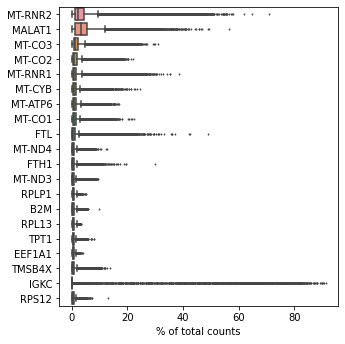

In [56]:
sc.pl.highest_expr_genes(adata, n_top=20)


In [59]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

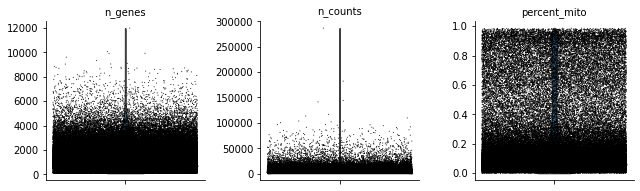

In [60]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Filter out cells with less than 200 genes detected and genes expressed in less than 3 cells

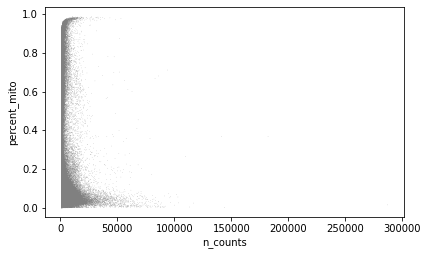

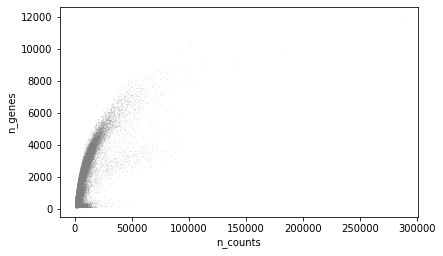

In [63]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [65]:
adata.obs

,filter_cells_min_counts,filter_cells_min_genes,filter_genes_min_cells,n_counts,n_genes,notes,pilot,replicate,sample,subtissue,tissue,percent_mito
AAACCCAAGCATCAAA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,12795,6776774,0,6855.0,2108,nan,TSP2,3,1,NA,Blood,0.068206
AAACCCAGTATTGGCT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,12795,6776774,0,4840.0,1667,nan,TSP2,3,1,NA,Blood,0.041314
AAACCCATCAACTCTT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,12795,6776774,0,1304.0,550,nan,TSP2,3,1,NA,Blood,0.269020
AAACCCATCTAGTTCT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,12795,6776774,0,13258.0,300,nan,TSP2,3,1,NA,Blood,0.159953
AAACCCATCTGACCCT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,12795,6776774,0,8011.0,2222,nan,TSP2,3,1,NA,Blood,0.082681
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTTTACTTC-1-1,2395,6786796,0,4931.0,1523,nan,TSP2,1,2,NA,LymphNode,0.139723
TTTGTTGTCCCGTAAA-1-1,2395,6786796,0,4637.0,1622,nan,TSP2,1,2,NA,LymphNode,0.135207
TTTGTTGTCCCTCATG-1-1,2395,6786796,0,6152.0,1910,nan,TSP2,1,2,NA,LymphNode,0.109912
TTTGTTGTCCTTCTAA-1-1,2395,6786796,0,3923.0,1615,nan,TSP2,1,2,NA,LymphNode,0.122701


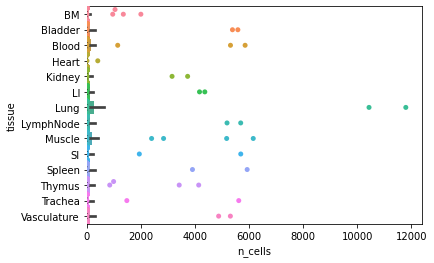

In [94]:
df = adata.obs.copy()
df['tissue'] = df['tissue'].astype(str)
df['subtissue'] = df['subtissue'].astype(str)
df = pd.DataFrame(df.groupby(['tissue','subtissue','sample','replicate'])['pilot'].count())
df = df.rename({'pilot':'n_cells'},axis=1)
df = df.reset_index()
ax = sns.swarmplot(data = df,y='tissue',x='n_cells')#,kind='swarm')
ax = sns.barplot(data = df,y='tissue',x='n_cells')#,kind='bar')